<a href="https://colab.research.google.com/github/Fidelisaboke/food-security-analysis/blob/main/food_security_status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Security Status Analysis



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import the required libraries

In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

## Load the Dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/dataFS.csv')
data.head()

,ID,site,hhedu,hhhage,hhhsex,hhethnic,hhsize,u05,povline,windex3,windex5,FS_score,FS
0,766,viwandani,primary,18,female,Other,6,1,yes,middle,fourth,0,Secure
1,6540,viwandani,primary,31,male,Other,1,0,yes,lowest,lowest,3,Severely insecure
2,9327,viwandani,primary,45,male,Other,1,0,no_(2),highest,fourth,0,Secure
3,9563,viwandani,secondary,18,male,Other,1,0,no_(2),middle,second,1,Moderately insecure
4,9631,korogocho,secondary,58,male,Other,2,1,no_(2),highest,fourth,0,Secure


## Exploratory Data Analysis (EDA)

### Dataset Information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10991 entries, 0 to 10990
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        10991 non-null  int64 
 1   site      10991 non-null  object
 2   hhedu     10974 non-null  object
 3   hhhage    10991 non-null  int64 
 4   hhhsex    10991 non-null  object
 5   hhethnic  10991 non-null  object
 6   hhsize    10991 non-null  int64 
 7   u05       10991 non-null  int64 
 8   povline   10991 non-null  object
 9   windex3   10991 non-null  object
 10  windex5   10991 non-null  object
 11  FS_score  10991 non-null  int64 
 12  FS        10991 non-null  object
dtypes: int64(5), object(8)
memory usage: 1.1+ MB


### Dataset Description

In [ ]:
data.describe()

,ID,hhhage,hhsize,u05,FS_score
count,10991.000000,10991.000000,10991.000000,10991.000000,10991.000000
mean,9364.528068,38.096443,3.211446,0.424529,1.238741
std,5388.489429,12.295378,2.032014,0.651529,1.217911
min,1.000000,18.000000,1.000000,0.000000,0.000000
25%,4676.500000,29.000000,1.000000,0.000000,0.000000
50%,9376.000000,36.000000,3.000000,0.000000,1.000000
75%,14048.500000,45.000000,4.000000,1.000000,2.000000
max,18704.000000,100.000000,20.000000,5.000000,4.000000


### Checking for Null Values


In [ ]:
data.isnull().sum()

,0
ID,0
site,0
hhedu,17
hhhage,0
hhhsex,0
hhethnic,0
hhsize,0
u05,0
povline,0
windex3,0


### Distribution by Site

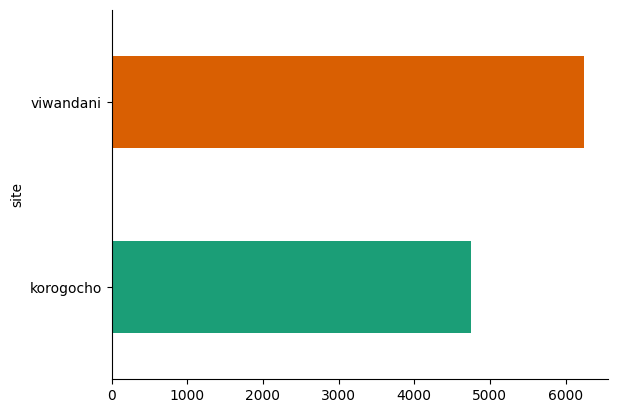

In [ ]:
data.groupby('site').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Distribution of Ethnicity

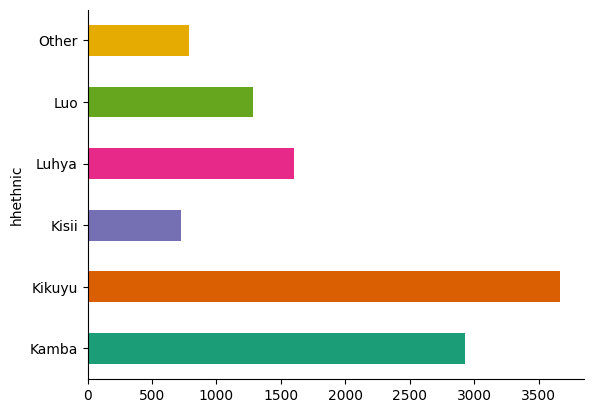

In [ ]:
data.groupby('hhethnic').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Food Security Score Distribution



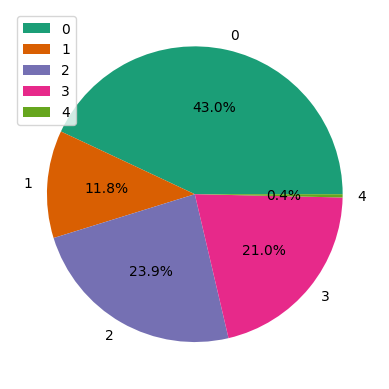

In [ ]:
data.groupby('FS_score').size().plot(kind='pie', autopct='%1.1f%%', colors=sns.palettes.mpl_palette('Dark2'))
plt.legend(loc='upper left')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Observations
- The pie chart shows that the food security score is low, indicating that
the food security is at a good level.
- The FS_score of 4 is underrepresented (0.4% of the data): This suggests the need for handling imbalance

## Data Preprocessing

### Drop Unnecessary Columns

In [4]:
data.drop(['ID','FS'], axis=1, inplace=True)
data.head()

,site,hhedu,hhhage,hhhsex,hhethnic,hhsize,u05,povline,windex3,windex5,FS_score
0,viwandani,primary,18,female,Other,6,1,yes,middle,fourth,0
1,viwandani,primary,31,male,Other,1,0,yes,lowest,lowest,3
2,viwandani,primary,45,male,Other,1,0,no_(2),highest,fourth,0
3,viwandani,secondary,18,male,Other,1,0,no_(2),middle,second,1
4,korogocho,secondary,58,male,Other,2,1,no_(2),highest,fourth,0


### Data Cleaning

In [5]:
# Ensure consistency in 'povline'
data['povline'] = data['povline'].replace({'no_(2)': 'no'})
data.head()

,site,hhedu,hhhage,hhhsex,hhethnic,hhsize,u05,povline,windex3,windex5,FS_score
0,viwandani,primary,18,female,Other,6,1,yes,middle,fourth,0
1,viwandani,primary,31,male,Other,1,0,yes,lowest,lowest,3
2,viwandani,primary,45,male,Other,1,0,no,highest,fourth,0
3,viwandani,secondary,18,male,Other,1,0,no,middle,second,1
4,korogocho,secondary,58,male,Other,2,1,no,highest,fourth,0


### Handling Missing Values

In [6]:
# Fill missing 'hhedu' with mode
data['hhedu'] = data['hhedu'].fillna(data['hhedu'].mode()[0])
data['hhedu'].isnull().sum()

np.int64(0)

## Data Encoding

### Ordinal Encoding
Ordinal Encoding the following columns to preserve ordering:
- hhedu
- windex3
- windex5

In [7]:
ordinal_columns = ['hhedu', 'windex3', 'windex5']
ordinal_encoder = OrdinalEncoder()
data[ordinal_columns] = ordinal_encoder.fit_transform(data[ordinal_columns])
data.head()

,site,hhedu,hhhage,hhhsex,hhethnic,hhsize,u05,povline,windex3,windex5,FS_score
0,viwandani,2.0,18,female,Other,6,1,yes,2.0,0.0,0
1,viwandani,2.0,31,male,Other,1,0,yes,1.0,2.0,3
2,viwandani,2.0,45,male,Other,1,0,no,0.0,0.0,0
3,viwandani,3.0,18,male,Other,1,0,no,2.0,4.0,1
4,korogocho,3.0,58,male,Other,2,1,no,0.0,0.0,0


### One-Hot Encoding
Applied to other textual/nominal columns

In [8]:
categorical_columns = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.head()

,hhedu,hhhage,hhsize,u05,windex3,windex5,FS_score,site_viwandani,hhhsex_male,hhethnic_Kikuyu,hhethnic_Kisii,hhethnic_Luhya,hhethnic_Luo,hhethnic_Other,povline_yes
0,2.0,18,6,1,2.0,0.0,0,True,False,False,False,False,False,True,True
1,2.0,31,1,0,1.0,2.0,3,True,True,False,False,False,False,True,True
2,2.0,45,1,0,0.0,0.0,0,True,True,False,False,False,False,True,False
3,3.0,18,1,0,2.0,4.0,1,True,True,False,False,False,False,True,False
4,3.0,58,2,1,0.0,0.0,0,False,True,False,False,False,False,True,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10991 entries, 0 to 10990
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hhedu            10991 non-null  float64
 1   hhhage           10991 non-null  int64  
 2   hhsize           10991 non-null  int64  
 3   u05              10991 non-null  int64  
 4   windex3          10991 non-null  float64
 5   windex5          10991 non-null  float64
 6   FS_score         10991 non-null  int64  
 7   site_viwandani   10991 non-null  bool   
 8   hhhsex_male      10991 non-null  bool   
 9   hhethnic_Kikuyu  10991 non-null  bool   
 10  hhethnic_Kisii   10991 non-null  bool   
 11  hhethnic_Luhya   10991 non-null  bool   
 12  hhethnic_Luo     10991 non-null  bool   
 13  hhethnic_Other   10991 non-null  bool   
 14  povline_yes      10991 non-null  bool   
dtypes: bool(8), float64(3), int64(4)
memory usage: 687.1 KB


## Feature Engineering

### Creating 'Dependency Ratio'
This may give insights into how many dependents under 5 years a household supports

In [9]:
data['dependency_ratio'] = data['u05'] / data['hhsize']
data['dependency_ratio']

,dependency_ratio
0,0.166667
1,0.000000
2,0.000000
3,0.000000
4,0.500000
...,...
10986,0.333333
10987,0.400000
10988,0.000000
10989,0.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10991 entries, 0 to 10990
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hhedu             10991 non-null  float64
 1   hhhage            10991 non-null  int64  
 2   hhsize            10991 non-null  int64  
 3   u05               10991 non-null  int64  
 4   windex3           10991 non-null  float64
 5   windex5           10991 non-null  float64
 6   FS_score          10991 non-null  int64  
 7   site_viwandani    10991 non-null  bool   
 8   hhhsex_male       10991 non-null  bool   
 9   hhethnic_Kikuyu   10991 non-null  bool   
 10  hhethnic_Kisii    10991 non-null  bool   
 11  hhethnic_Luhya    10991 non-null  bool   
 12  hhethnic_Luo      10991 non-null  bool   
 13  hhethnic_Other    10991 non-null  bool   
 14  povline_yes       10991 non-null  bool   
 15  dependency_ratio  10991 non-null  float64
dtypes: bool(8), float64(4), int64(4)
memory 

## Obtaining the Features and Label


In [10]:
X = data.drop('FS_score', axis=1)
y = data['FS_score']
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (10991, 15)
y shape: (10991,)


### Distribution of Target

In [ ]:
y.value_counts()

,count
FS_score,
0,4729
2,2624
3,2306
1,1293
4,39


## Resampling using SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"X_resampled shape: {X_resampled.shape}")
print(f"y_resampled shape: {y_resampled.shape}")

X_resampled shape: (23645, 15)
y_resampled shape: (23645,)


## Splitting into Training and Testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    stratify=y_resampled,
    test_size=0.2,
    random_state=42
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (18916, 15)
X_test shape: (4729, 15)
y_train shape: (18916,)
y_test shape: (4729,)


## Data Scaling

### Standard Scaling

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Results after Standard Scaling

In [14]:
X_train_scaled

array([[-0.09968078,  1.45671427, -0.18948819, ..., -0.32627849,
         0.87259974, -0.72188741],
       [ 0.43447196, -0.65544949, -1.16363102, ..., -0.32627849,
        -1.1460008 , -0.72188741],
       [ 0.97243185, -0.81792362, -0.6765596 , ..., -0.32627849,
         0.87259974, -0.72188741],
       ...,
       [-0.51345745,  0.48186946,  1.75879747, ..., -0.32627849,
         0.87259974, -0.72188741],
       [ 0.97243185,  0.40063239,  0.29758323, ..., -0.32627849,
         0.87259974,  1.04813816],
       [ 0.91384106,  1.05052893,  0.29758323, ..., -0.32627849,
         0.87259974, -0.72188741]])

In [15]:
X_test_scaled

array([[-0.25526696, -1.30534603, -0.6765596 , ..., -0.32627849,
        -1.1460008 , -0.72188741],
       [ 0.97243185, -1.3865831 , -1.16363102, ..., -0.32627849,
        -1.1460008 , -0.72188741],
       [ 0.97243185, -0.98039776, -0.6765596 , ..., -0.32627849,
        -1.1460008 , -0.72188741],
       ...,
       [ 0.97243185, -0.65544949, -0.6765596 , ..., -0.32627849,
         0.87259974, -0.72188741],
       [-1.2995671 ,  1.21300307,  1.27172606, ..., -0.32627849,
         0.87259974,  0.36894565],
       [ 0.856605  , -0.00555295,  0.29758323, ...,  3.06486649,
         0.87259974,  0.58375256]])

## Model Training and Evaluation


### Decision Tree Classifier

#### Finding the Best Classifier

In [ ]:
# Finding the best parameters using GridSearchCV
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 25],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(decision_tree, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Evaluating the Best Classifier

In [ ]:
# Access the best decision tree classifier
best_dt = grid.best_estimator_

# Evaluate the decision tree classifier
y_pred_decision_tree = best_dt.predict(X_test_scaled)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.45      0.44      0.45       946
           1       0.61      0.63      0.62       945
           2       0.51      0.50      0.50       946
           3       0.57      0.56      0.57       946
           4       0.97      0.99      0.98       946

    accuracy                           0.62      4729
   macro avg       0.62      0.62      0.62      4729
weighted avg       0.62      0.62      0.62      4729



#### Decision Tree Classifier Confusion Matrix

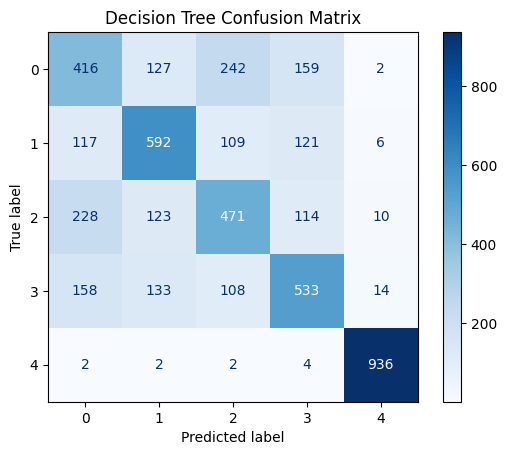

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_dt,
    X_test_scaled,
    y_test,
    display_labels=best_dt.classes_,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

#### Decision Tree Feature Importance

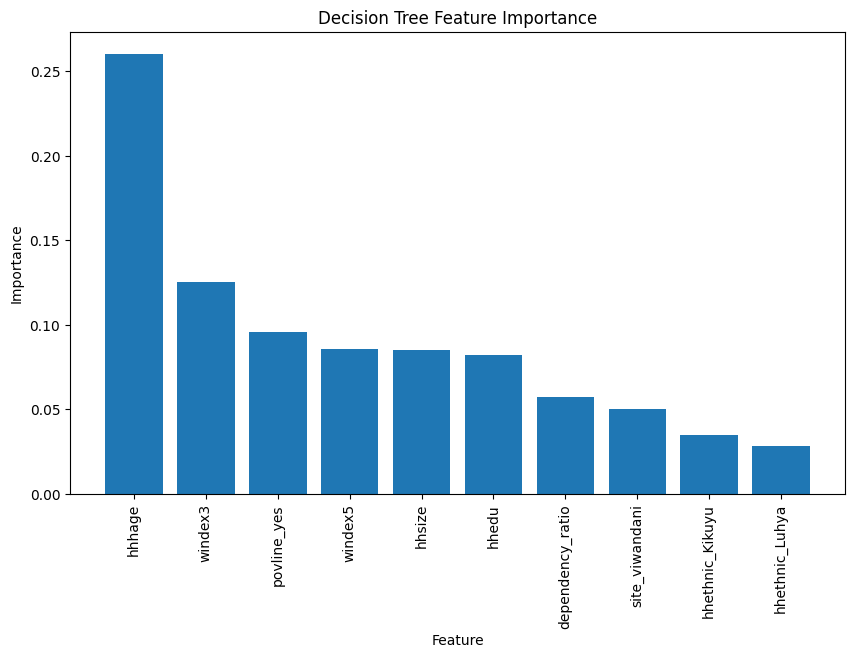

In [ ]:
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

n = 10

plt.figure(figsize=(10, 6))
plt.title("Decision Tree Feature Importance")
plt.bar(range(n), importances[indices[:n]], align="center")
plt.xticks(range(n), [features[i] for i in indices[:n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### Random Forest Classifier

#### Finding the Best Classifier

In [ ]:
# Finding the best parameters using RandomizedSearchCV
random_forest = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

rand_search = RandomizedSearchCV(random_forest, param_dist, n_iter=5, cv=5)
rand_search.fit(X_train_scaled, y_train)
print(f"Best Parameters: {rand_search.best_params_}")

Best Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 22, 'n_estimators': 963}


#### Evaluating the Best Classifier

In [ ]:
best_rf = rand_search.best_estimator_

# Evaluate the random forest classifier
y_pred_random_forest = best_rf.predict(X_test_scaled)
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       946
           1       0.61      0.60      0.60       945
           2       0.53      0.53      0.53       946
           3       0.56      0.61      0.58       946
           4       0.92      1.00      0.96       946

    accuracy                           0.64      4729
   macro avg       0.63      0.64      0.63      4729
weighted avg       0.63      0.64      0.63      4729



#### Random Forest Confusion Matrix

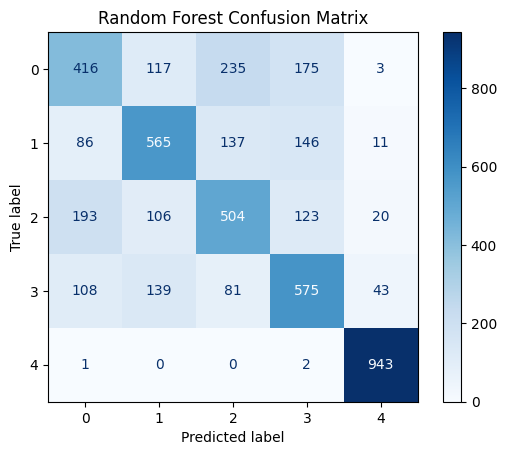

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test_scaled,
    y_test,
    display_labels=best_rf.classes_,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()

#### Random Forest Feature Importance

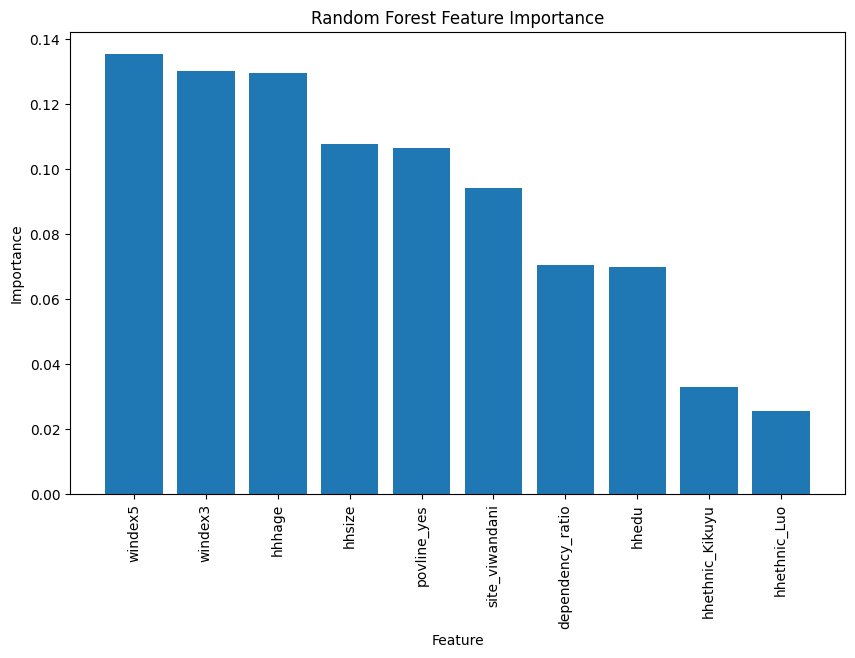

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

n = 10

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(n), importances[indices[:n]], align="center")
plt.xticks(range(n), [features[i] for i in indices[:n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

## XGBoost

### Model Training

In [17]:
# Intialize XGBoost model
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    random_state=42
)

# GridSearchCV for selecting best parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(xgb, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


### Model Evaluation


In [18]:
best_xgb = grid.best_estimator_

# Evaluate the XGBoost model
y_pred_xgb = best_xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       946
           1       0.73      0.71      0.72       945
           2       0.62      0.58      0.60       946
           3       0.67      0.69      0.68       946
           4       0.98      1.00      0.99       946

    accuracy                           0.70      4729
   macro avg       0.70      0.70      0.70      4729
weighted avg       0.70      0.70      0.70      4729



### XGBoost Confusion Matrix

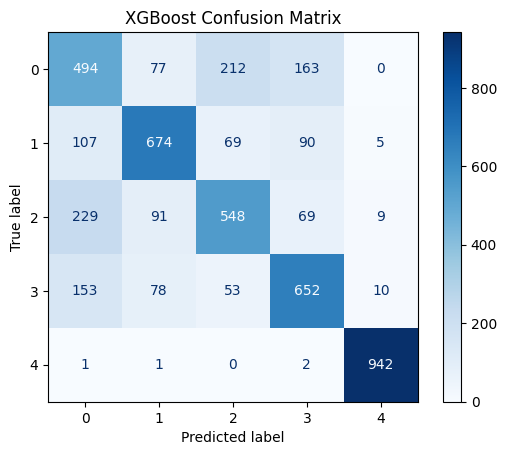

In [19]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_xgb,
    X_test_scaled,
    y_test,
    display_labels=best_xgb.classes_,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("XGBoost Confusion Matrix")
plt.show()

### Feature Importance

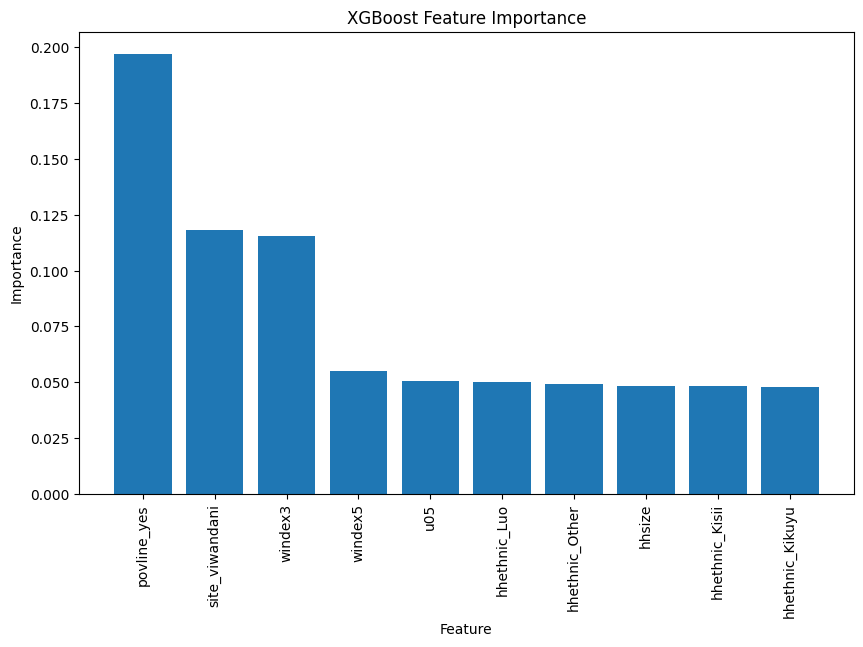

In [20]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

n = 10

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance")
plt.bar(range(n), importances[indices[:n]], align="center")
plt.xticks(range(n), [features[i] for i in indices[:n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### Saving the Model and Scaler

In [21]:
joblib.dump(best_xgb, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Conclusion
Three models were trained and evaluated based on the dataset:
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier

Based on the results obtained during model evaluation, XGBoost performs significantly better compared to Decision Tree and Random Forest Classifiers, reporting fairly better results across the board.
The metrics also show that class 4 is almost perfectly detected, as a result of SMOTE and stratification.